<a href="https://colab.research.google.com/github/kumarneeraj2005/2048-Deep-Learning/blob/master/Deep_Writing_with_sentence_word_prediction_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import regex as re

import nltk
from nltk.draw.dispersion import dispersion_plot
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.probability import FreqDist
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
nltk.download('averaged_perceptron_tagger')
from nltk.util import ngrams
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding

from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

import urllib

import os

# Any results you write to the current directory are saved as output.
# from google.colab import drive
# drive.mount('/content/gdrive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Using TensorFlow backend.


In [2]:
text = urllib.request.urlopen('http://www.textfiles.com/stories/3gables.txt').read().decode('utf8')
text = text.replace('\n', ' ').replace('\r', '').replace("\'", "").replace('\w+', '')[348:500]
text[0:1000]

'   I dont think that any of my adventures with Mr. Sherlock Holmes opened quite so abruptly, or so dramatically, as that which I associate with The Thre'

In [0]:
# I will first convert all the words to numbers, then normalize them, then make a dataframe with two columns, 
# one with sentences(one word, then two words, and so on), the other with the exact next word

In [0]:
# integer encode text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
encoded = tokenizer.texts_to_sequences([text])[0]

In [0]:
# determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 24


In [0]:
# x = pd.DataFrame(pd.Series([encoded[:i] for i in range(len(encoded))]))
# x['label'] = pd.DataFrame([i for i in encoded])
# x.head()

In [0]:
listy = []

for i in range(len(encoded)):
  listy.append(encoded[:i])
  
len(listy)

27

In [0]:
listy[1:10]

[[1],
 [1, 5],
 [1, 5, 6],
 [1, 5, 6, 2],
 [1, 5, 6, 2, 7],
 [1, 5, 6, 2, 7, 8],
 [1, 5, 6, 2, 7, 8, 9],
 [1, 5, 6, 2, 7, 8, 9, 10],
 [1, 5, 6, 2, 7, 8, 9, 10, 3]]

In [0]:
# np.array([np.array(xi) for xi in listy[1:]]) # creating array retaining the shape

In [0]:
length = len(sorted(listy[1:],key = len, reverse = True)[0])   # creating array by adding 0 to make all rows equal
X = np.array([xi + [0] * (length - len(xi)) for xi in listy[1:]])
X.shape  # creating X array

(26, 26)

In [0]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
X[0]

array([ 0.        , -5.        , -3.46410162, -2.76887462, -2.34520788,
       -2.04939015, -1.82574186, -1.64750894, -1.5       , -1.37436854,
       -1.26491106, -1.16774842, -1.08012345, -1.        , -0.9258201 ,
       -0.85634884, -0.79056942, -0.72760688, -0.66666667, -0.60697698,
       -0.54772256, -0.48795004, -0.42640143, -0.36115756, -0.28867513,
       -0.2       ])

In [0]:
y = [i for i in encoded][1:] # creating y array
len(y)

26

In [0]:
# one hot encode outputs
y = to_categorical(y, num_classes = vocab_size)

In [0]:
y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [0]:
X.shape, y.shape

((26, 26), (26, 24))

In [0]:
# LSTMs accept input in the form of (number_of_sequences, length_of_sequence, number_of_features)
X_lstm = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_lstm.shape

(26, 26, 1)

In [0]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape = (X_lstm.shape[1], X_lstm.shape[2])))#, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(50, return_sequences = True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(500, return_sequences = True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(500, return_sequences = True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(2500, return_sequences = True))
# model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.LSTM(50))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(y.shape[1], activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
Total params: 11,624
Trainable params: 11,624
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
tf.logging.set_verbosity(tf.logging.INFO)

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.86.123.98:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 9908395419379460952)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 11439517981440160975)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1212404706152780327)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1

In [0]:
tpu_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      (None, 26, 1)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                1224      
Total params: 11,624
Trainable params: 11,624
Non-trainable params: 0
_________________________________________________________________


In [0]:
#early_stopping_monitor = EarlyStopping(monitor = 'loss', patience = 4, verbose = 0, mode='auto')
tpu_model.fit(X_lstm, y, epochs = 500, batch_size = 50)#, callbacks = [early_stopping_monitor])

Epoch 1/500
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(3,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(3, 26, 1), dtype=tf.float32, name='lstm_input_10'), TensorSpec(shape=(3, 24), dtype=tf.float32, name='dense_target_30')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 0.0, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for lstm_input
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fa3d1df2898> []
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.108351707458496 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta

No handles with labels found to put in legend.


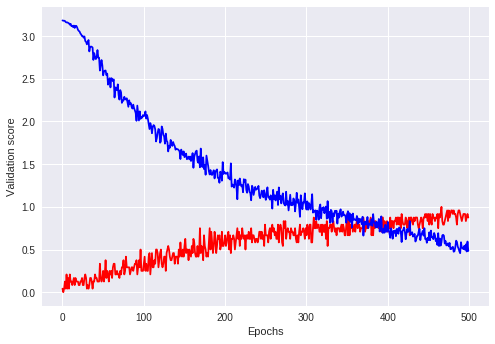

In [0]:
# Create the plot
plt.plot(tpu_model.history.history['acc'], 'r', tpu_model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.legend()
plt.show()

In [0]:
cpu_model = tpu_model.sync_to_cpu()

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


In [0]:
cpu_model.save_weights('Deep_Writing_with_sentence-word_prediction-tpu.h5')

In [0]:
cpu_model.load_weights('Deep_Writing_with_sentence-word_prediction-tpu.h5')

In [0]:
X[9]

array([ 0.        ,  0.2       ,  0.28867513,  0.36115756,  0.42640143,
        0.48795004,  0.54772256,  0.60697698,  0.66666667,  0.72760688,
       -1.26491106, -1.16774842, -1.08012345, -1.        , -0.9258201 ,
       -0.85634884, -0.79056942, -0.72760688, -0.66666667, -0.60697698,
       -0.54772256, -0.48795004, -0.42640143, -0.36115756, -0.28867513,
       -0.2       ])

In [0]:
X_lstm[0:10].shape

(10, 26, 1)

In [0]:
pred = cpu_model.predict(X_lstm[0:])
print(pred.shape)
line = []
for i in range(len(pred)):
  line.append(tokenizer.index_word[np.argmax(pred[i])])
  
' '.join(line)

(26, 24)


'that of any dont of my adventures with mr sherlock holmes opened quite so or or so dramatically as that which i associate with the thre'